In [1]:
import os
import numpy as np
np.random.bit_generator = np.random._bit_generator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [2]:
dirc = 'dataset_sdc'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(dirc, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/manish/Documents/SDC/dataset2/IMG/center_2020_01_03_00_12_30_721.jpg,/Users/manish/Documents/SDC/dataset2/IMG/left_2020_01_03_00_12_30_721.jpg,/Users/manish/Documents/SDC/dataset2/IMG/right_2020_01_03_00_12_30_721.jpg,0.0,0.0,0.0,0.000062
1,/Users/manish/Documents/SDC/dataset2/IMG/center_2020_01_03_00_12_30_821.jpg,/Users/manish/Documents/SDC/dataset2/IMG/left_2020_01_03_00_12_30_821.jpg,/Users/manish/Documents/SDC/dataset2/IMG/right_2020_01_03_00_12_30_821.jpg,0.0,0.0,0.0,0.000062
2,/Users/manish/Documents/SDC/dataset2/IMG/center_2020_01_03_00_12_30_924.jpg,/Users/manish/Documents/SDC/dataset2/IMG/left_2020_01_03_00_12_30_924.jpg,/Users/manish/Documents/SDC/dataset2/IMG/right_2020_01_03_00_12_30_924.jpg,0.0,0.0,0.0,0.000062
3,/Users/manish/Documents/SDC/dataset2/IMG/center_2020_01_03_00_12_31_072.jpg,/Users/manish/Documents/SDC/dataset2/IMG/left_2020_01_03_00_12_31_072.jpg,/Users/manish/Documents/SDC/dataset2/IMG/right_2020_01_03_00_12_31_072.jpg,0.0,0.0,0.0,0.000064
4,/Users/manish/Documents/SDC/dataset2/IMG/center_2020_01_03_00_12_31_173.jpg,/Users/manish/Documents/SDC/dataset2/IMG/left_2020_01_03_00_12_31_173.jpg,/Users/manish/Documents/SDC/dataset2/IMG/right_2020_01_03_00_12_31_173.jpg,0.0,0.0,0.0,0.000062


In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2020_01_03_00_12_30_721.jpg,left_2020_01_03_00_12_30_721.jpg,right_2020_01_03_00_12_30_721.jpg,0.0,0.0,0.0,0.000062
1,center_2020_01_03_00_12_30_821.jpg,left_2020_01_03_00_12_30_821.jpg,right_2020_01_03_00_12_30_821.jpg,0.0,0.0,0.0,0.000062
2,center_2020_01_03_00_12_30_924.jpg,left_2020_01_03_00_12_30_924.jpg,right_2020_01_03_00_12_30_924.jpg,0.0,0.0,0.0,0.000062
3,center_2020_01_03_00_12_31_072.jpg,left_2020_01_03_00_12_31_072.jpg,right_2020_01_03_00_12_31_072.jpg,0.0,0.0,0.0,0.000064
4,center_2020_01_03_00_12_31_173.jpg,left_2020_01_03_00_12_31_173.jpg,right_2020_01_03_00_12_31_173.jpg,0.0,0.0,0.0,0.000062


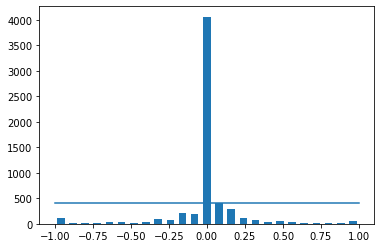

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [5]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 

total data: 6038


removed: 3672
remaining: 2366


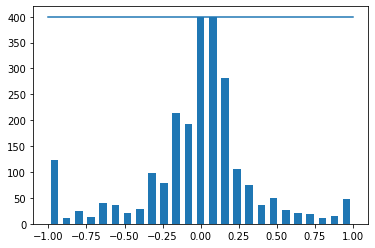

In [6]:
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [7]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

center      center_2020_01_03_00_12_31_706.jpg
left        left_2020_01_03_00_12_31_706.jpg  
right       right_2020_01_03_00_12_31_706.jpg 
steering   -1                                 
throttle    0                                 
reverse     0                                 
speed       0.000156647                       
Name: 9, dtype: object


In [8]:
image_paths, steerings = load_img_steering(dirc + '/IMG', data)


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))


Training Samples: 5678
Valid Samples: 1420


Text(0.5, 1.0, 'Validation set')

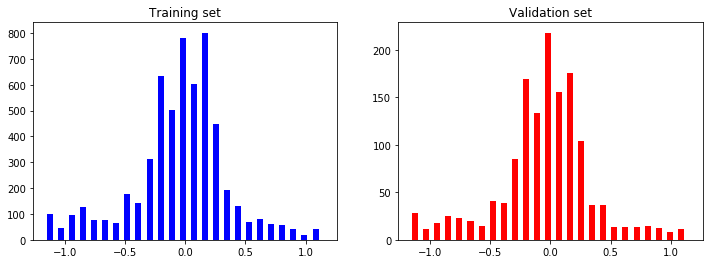

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [11]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [12]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)


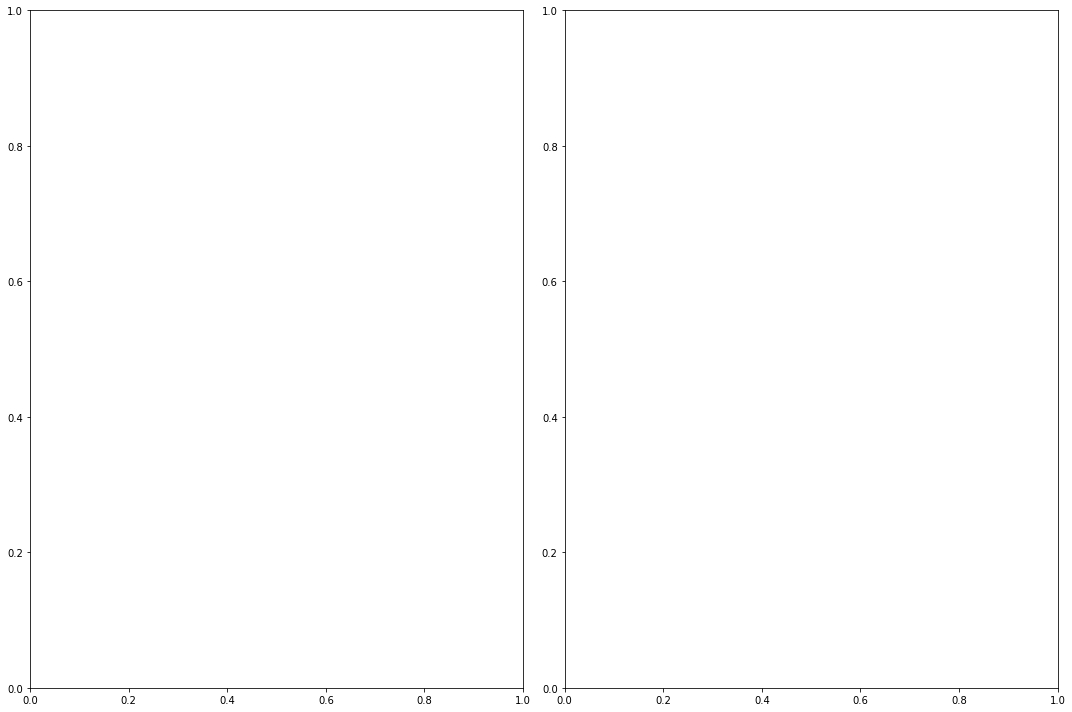

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

In [14]:
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

Text(0.5, 1, 'Original Image')

In [ ]:
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image


In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

In [ ]:
axs[0].imshow(original_image)
axs[0].set_title('Original Image')


In [ ]:
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

In [ ]:
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

In [ ]:
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')


In [ ]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [ ]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

In [ ]:
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

In [ ]:
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))


In [ ]:
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))


In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle


In [ ]:
ncol = 2
nrow = 10

In [ ]:
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

In [ ]:
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [ ]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  


In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()


In [ ]:
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

In [ ]:
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [ ]:
model = nvidia_model()
print(model.summary())

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
